In [1]:
%load_ext autoreload
%autoreload 2
from collections import OrderedDict
from datasets import load_dataset
from more_itertools import chunked
from itda import ITDAConfig, ITDA
from tqdm.auto import tqdm
import numpy, torch
import json, os
os.makedirs("dataset", exist_ok=True)

In [2]:
import torch
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [3]:
torch.set_grad_enabled(False)

In [4]:
import numpy as np
nf4 = np.asarray(
    [
        -1.0,
        -0.6961928009986877,
        -0.5250730514526367,
        -0.39491748809814453,
        -0.28444138169288635,
        -0.18477343022823334,
        -0.09105003625154495,
        0.0,
        0.07958029955625534,
        0.16093020141124725,
        0.24611230194568634,
        0.33791524171829224,
        0.44070982933044434,
        0.5626170039176941,
        0.7229568362236023,
        1.0,
    ]
)
image_max = 6.0

In [5]:
@torch.compile(mode="max-autotune")
def strip_high_cossim(x, threshold=0.8, remove_pct = 0.5):
    x = x - x.mean(0)
    x = x / x.norm(dim=-1, keepdim=True)
    has_duplicate = ((x @ x.T - 2 * torch.eye(x.shape[0], device=x.device, dtype=x.dtype)) > threshold).any(dim=-1)
    rand_mask = (torch.rand_like(has_duplicate, dtype=torch.float16) < remove_pct)
    return ~(has_duplicate & rand_mask)

In [13]:
prompts_dataset = load_dataset("opendiffusionai/cc12m-cleaned")
prompts_iterator = prompts_dataset["train"]["caption_llava_short"]
guidance_scale = 3.5
num_inference_steps = 1
batch_size = 32
width = 256
height = 256
d_model = 3072
itda_config = ITDAConfig(
    d_model=d_model,
    target_l0=32,
    loss_threshold=0.5,
    add_error=False,
    fvu_loss=True,
    subtract_mean=True,
)
normalize = True
device = torch.device("cuda:0")
itda = ITDA(itda_config, dtype=torch.bfloat16, device=device)
losses = []
dictionary_sizes = []
stds = None
for i, prompts in enumerate(chunked((bar := tqdm(prompts_iterator)), batch_size)):
    with torch.inference_mode():
        for m in pipe.transformer.modules():
            m._forward_hooks = OrderedDict()
        text_outputs = {}
        image_outputs = {}
        timestep = 0
        def save_hook(self, input, output):
            text_outputs[timestep] = output[0]
            image_outputs[timestep] = output[1]
        pipe.transformer.transformer_blocks[18].register_forward_hook(save_hook)
        height = 256
        width = 256
        def callback_on_step_end(self, i, t, kwargs):
            global timestep
            timestep = i
            return {}
        pipe.set_progress_bar_config(disable=True)
        with torch.inference_mode():
            latents = pipe(
                prompts,
                height=height,
                width=width,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                max_sequence_length=512,
                generator=torch.Generator("cpu").manual_seed(0),
                return_dict=False,
                callback_on_step_end=callback_on_step_end,
                output_type="latent",
            )[0]
        latents_reshaped = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)
        latents_to_be_compressed = latents_reshaped.cpu().float().numpy()
        latents_to_save = (latents_to_be_compressed / image_max).clip(-1, 1)
        latents_to_save = np.abs(latents_to_save[..., None] - nf4).argmin(-1).astype(np.uint8)
        latents_to_save = (
            (latents_to_save[..., ::2] & 0x0F)
            | ((latents_to_save[..., 1::2] << 4) & 0xF0))
        np.savez_compressed(f"dataset/batch-{i}.npz", latents_to_save)
        json.dump(dict(
            prompts=prompts,
            step=i,
            batch_size=batch_size,
            width=width,
            height=height,
            guidance_scale=3.5,
            num_inference_steps=num_inference_steps,
        ), open(f"dataset/batch-{i}.json", "w"))
        x = image_outputs[0].to(torch.bfloat16).to(device)
        x = x.reshape(-1, d_model)
        
        if normalize:
            if stds is None:
                stds = x.std(dim=0, unbiased=False)
            x = x / stds

        out = itda.step(x, x)
        if out is None:
            continue
        loss = out.losses.mean().item()
        bar.set_postfix(
            loss=loss,
            dictionary_size=itda.dictionary_size
        )
        losses.append(loss)
        dictionary_sizes.append(itda.dictionary_size)
        

        # if i % 10 == 9:
        #     xs = itda.xs[:itda.dictionary_size]
        #     mask = strip_high_cossim(xs)
        #     itda.xs.data = xs[mask]
        #     itda.ys.data = itda.ys[:itda.dictionary_size][mask]
        #     itda.dictionary_size = mask.sum().item()
        #     print("Pruning at step", i, "complete. Pruned", (~mask).sum().item(), "vectors.")


  0%|          | 0/8531902 [00:00<?, ?it/s]

KeyboardInterrupt: 

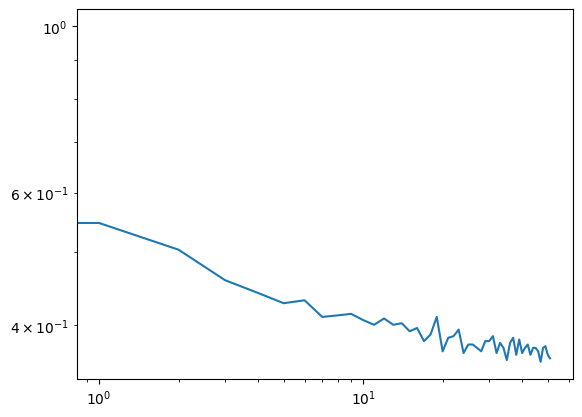

In [15]:
import matplotlib.pyplot as plt

plt.loglog(losses)

In [16]:
itda.std_x.data = stds

In [17]:
itda.save_to_disk("itda_1800_steps_256_32_k")

In [9]:
itda.save_to_disk("itda_12k_steps_256")

In [9]:
itda.save_to_disk("itda_72k_steps_256")

In [10]:
itda.load_from_disk("itda_72k_steps_256")

ITDA()

In [11]:
itda.std_x

Parameter containing:
tensor([5.5625, 4.5938, 4.1875,  ..., 3.9219, 3.9844, 8.3750], device='cuda:0',
       dtype=torch.bfloat16)

In [10]:
xs = itda.xs[:itda.dictionary_size]
mask = strip_high_cossim(xs)
itda.xs.data = xs[mask]
itda.ys.data = itda.ys[:itda.dictionary_size][mask]
itda.dictionary_size = mask.sum().item()
print("Pruning at step", i, "complete. Pruned", (~mask).sum().item(), "vectors.")

AUTOTUNE mm(22152x3072, 3072x22152)
  mm 4.4419 ms 100.0% 
  triton_mm_18 5.5684 ms 79.8% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_17 5.6083 ms 79.2% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=3, num_warps=4
  triton_mm_16 6.7358 ms 65.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=32, BLOCK_M=128, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=3, num_warps=4
  triton_mm_12 7.4153 ms 59.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=128, BLOCK_M=64, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=4, num_warps=4
  triton_mm_11 8.0727 ms 55.0% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=64, BLOCK_M=64, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=3, num_warps=4
  trito

Pruning at step 1006 complete. Pruned 2295 vectors.


In [11]:
itda.save_to_disk("itda_32k_steps_256_pruned")

In [ ]:
dictionary = itda.xs[:itda.dictionary_size].float().cpu().numpy()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(dictionary)

PCA()

: 